In [69]:
import logging
from tqdm import tqdm

import dask.dataframe as dd, pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt, seaborn as sns

plt.rcParams["figure.figsize"] = (28, 6)
plt.style.use("ggplot")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Here we will consider the task of predicting the `etcusd` pair using a selection of other pairs. A possible application of this is to construct innovations which can be used in a statistical arbitrage strategy. The most obvious approach to dealing with heteroskedasticity/nonstationarity is to normalise features & targets across time (or perhaps take a z-score). But another approach, which is used here, is to model heteroskedasticity directly. Here, an MLP is constructed with two outputs: mean and variance. Due to compute constraints, we just consider a single train-test pair.

## Data Preparation

In [70]:
USECOLS = ("time", "open", "close", "high", "low", "volume", "pair_name", "date")

In [71]:
data = dd.read_csv("data/*", usecols=USECOLS)

daily_prices = data.groupby(["date", "pair_name"]).last().compute()
daily_prices = daily_prices.reset_index().pivot(
    values="close", index="date", columns="pair_name"
)
daily_prices.index = pd.to_datetime(daily_prices.index)

KeyboardInterrupt: 

The below plots show highlight the nonstationarity, including heteroskedasticity.

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


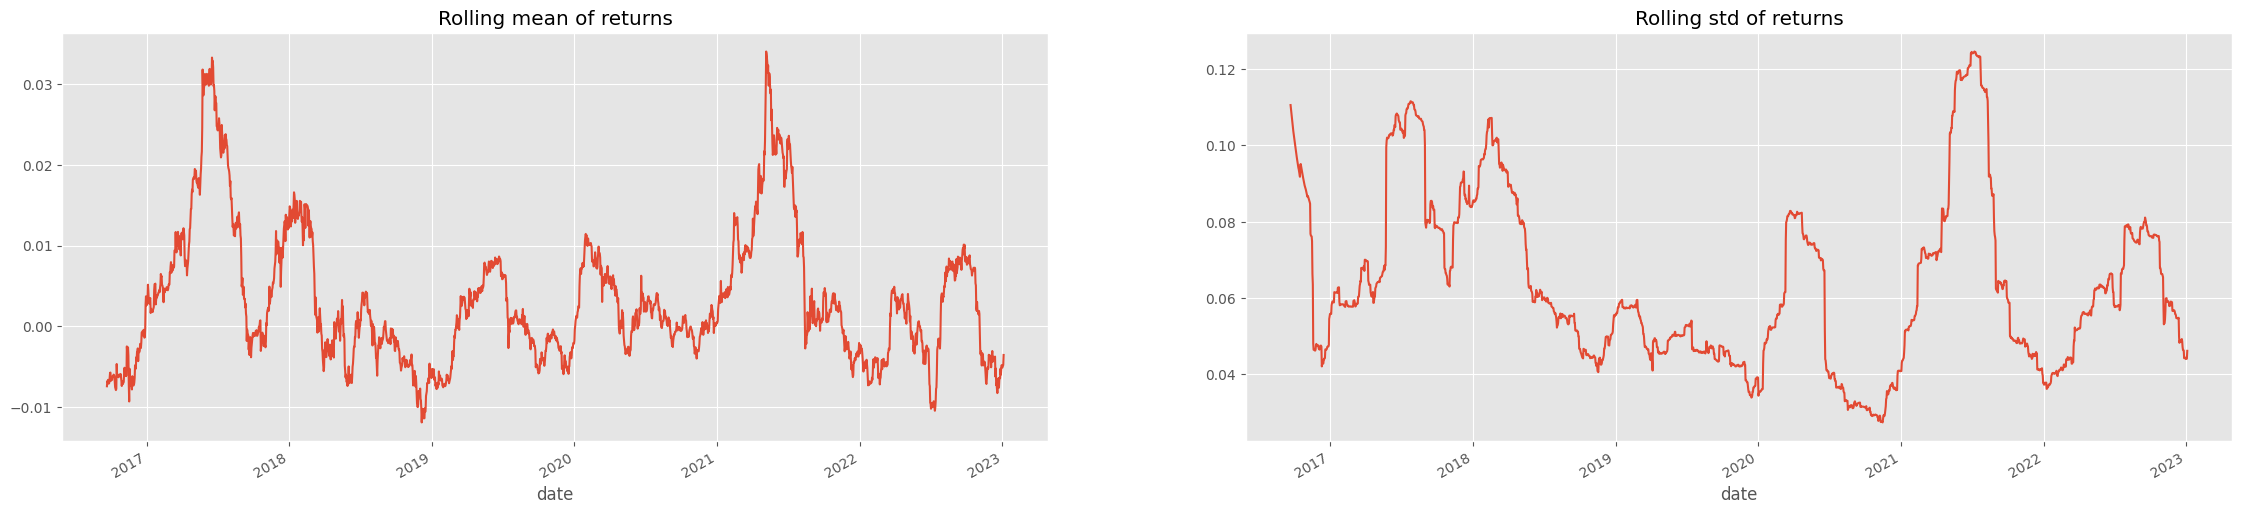

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(28, 6))

daily_prices["etcusd"].pct_change().rolling(100, 50).mean().plot(ax=axs[0])
axs[0].set_title("Rolling mean of returns")

daily_prices["etcusd"].pct_change().rolling(100, 50).std().plot(ax=axs[1])
axs[1].set_title("Rolling std of returns")

fig.show()

We consider a small number of other pairs to use as predictors. We select these based on those with most available data, in the hope that this does not induce too much bias.

In [ ]:
N_LARGEST = 20

In [ ]:
pairs = daily_prices.count().sort_values(ascending=False).index[:N_LARGEST]
daily_prices = daily_prices[pairs]
log_returns = np.log(1 + daily_prices.pct_change()).dropna(how="any")
log_returns.shape

(1913, 20)

We can visualise the correlations between the different pairs:

In [ ]:
def plot_clustermap(df, corr=True):
    if corr:
        df = df.corr(method="spearman")
    return sns.clustermap(
        df,
        method="complete",
        cmap="RdBu",
        annot=True,
        fmt=".2f",
        annot_kws={"size": 7},
        vmin=-1,
        vmax=1,
        figsize=(15, 12),
    )

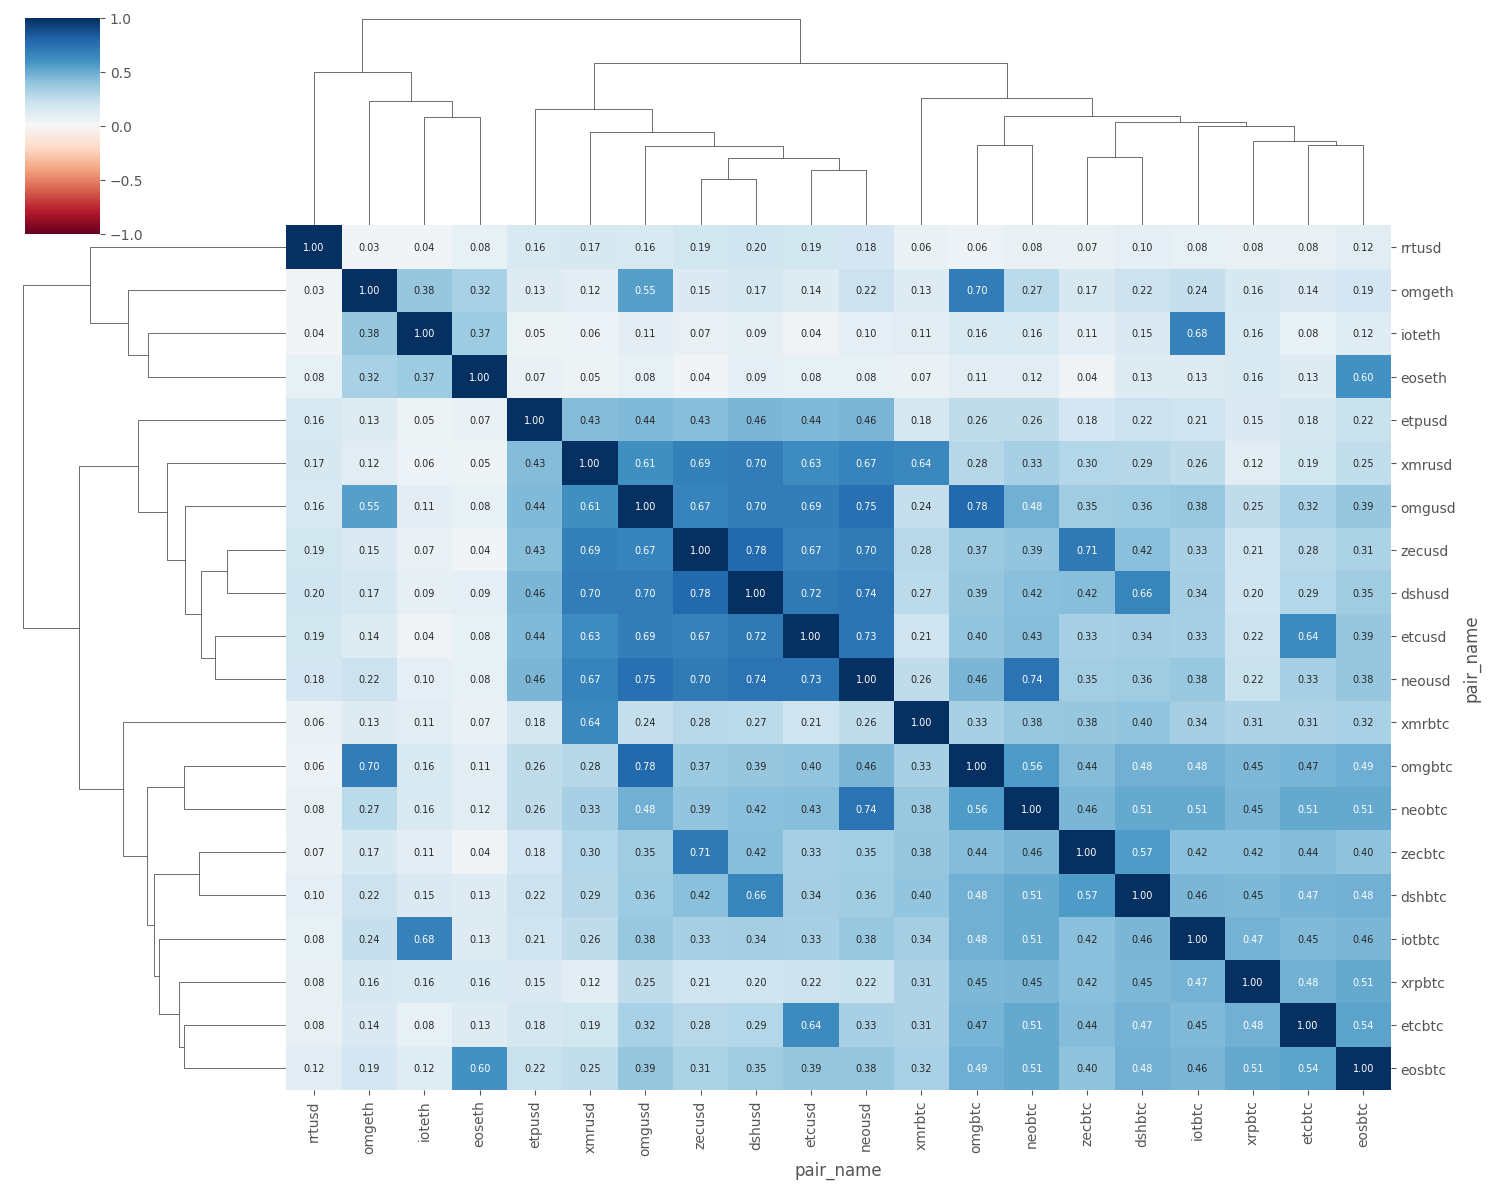

In [ ]:
plot_clustermap(log_returns)

## Model Fitting

Below we define the neural network architecture, consisting of a common MLP body, with two separate heads for the prediction of the mean and the prediction of the variance.

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_dims):
        super().__init__()
        self.net = []
        for dim_in, dim_out in zip(
            layer_dims[:-2], layer_dims[1:-1]
        ):  # all layers up to final one
            self.net.append(nn.Linear(dim_in, dim_out))
            self.net.append(nn.LeakyReLU())
        self.net.append(nn.Linear(layer_dims[-2], layer_dims[-1]))  # final layer
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)


class MultiHeadMLP(nn.Module):
    def __init__(self, shared_layer_dims, head_layer_dims):
        super().__init__()
        self.shared_mlp = MLP(shared_layer_dims)
        self.mean_mlp = MLP(head_layer_dims)
        self.var_mlp = MLP(head_layer_dims)

    def forward(self, x):
        x = self.shared_mlp.forward(x)
        mean = self.mean_mlp.forward(x)
        var = torch.square(self.var_mlp.forward(x))
        return mean, var

We also define a class for a dataset which can be converted to a `DataLoader` object.

In [ ]:
class TorchDataset(Dataset):
    def __init__(self, df, feature_names, target_name, idxs):
        self.X = torch.tensor(df.loc[idxs, feature_names].values, dtype=torch.float32)
        self.y = torch.tensor(df.loc[idxs, target_name].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

The following defines universal constants and the functionality for training and evaluating the model.

In [74]:
TARGET_NAME = "etcusd"
FEATURE_NAMES = log_returns.columns.drop(TARGET_NAME)
SHARED_LAYER_DIMS = (len(FEATURE_NAMES), 50, 20, 10)
HEAD_LAYER_DIMS = (10, 5, 1)
DEVICE = "gpu" if torch.cuda.is_available() else "cpu"
EPOCHS = 500
LR = 1e-3
MOMENTUM = 0
BATCH_SIZE = 100
TEST_PROP = 0.3

In [87]:
def train_test_split(idx, test_prop):
    """Splits a pandas index idx into a train_idx and test_idx."""
    n_test = int(len(idx) * test_prop)
    return idx[:-n_test], idx[-n_test:]


def train_torch_model_epoch(
    model, train_loader, optimiser, loss_fn, device, batch_size
):
    running_loss = 0
    model.train()
    for k, (input, mean_true) in enumerate(
        train_loader
    ):  # tqdm(enumerate(train_loader)):
        optimiser.zero_grad()  # zero the gradients on this batch
        mean_pred, var_pred = model(input)  # make predictions on this batch
        mean_pred.to(device), var_pred.to(device)  # send to device
        loss = loss_fn(mean_pred, mean_true.to(device), var_pred)
        loss.backward()  # compute gradients of the loss
        optimiser.step()  # adjust weights
        running_loss += loss.item()
    return running_loss / batch_size


def test_torch_model_epoch(model, test_loader, loss_fn, device, batch_size):
    running_loss = 0
    model.eval()
    for k, (input, mean_true) in enumerate(
        test_loader
    ):  # tqdm(enumerate(test_loader)):
        mean_pred, var_pred = model(input)
        mean_pred.to(device), var_pred.to(device)
        running_loss += loss_fn(mean_pred, mean_true.to(device), var_pred)
    return running_loss / batch_size


def train_torch_model(
    model,
    train_loader,
    test_loader,
    device,
    batch_size,
    epochs,
    lr,
    momentum,
):
    optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.GaussianNLLLoss()
    inSampleLosses = []
    outOfSampleLosses = []
    for epoch in range(epochs):
        is_loss = train_torch_model_epoch(
            model, train_loader, optimiser, loss_fn, device, batch_size
        )
        inSampleLosses.append(is_loss)
        oos_loss = test_torch_model_epoch(
            model, test_loader, loss_fn, device, batch_size
        )
        outOfSampleLosses.append(oos_loss)
        if (epoch + 1) % 20 == 0:
            logger.info(
                f"EPOCH {epoch+1}: In-sample loss = {is_loss}, Out-of-sample loss = {oos_loss}."
            )
        # torch.save(model.state_dict(), f"model_{epoch+1}")
    return inSampleLosses, outOfSampleLosses


def run_model_fitting(
    df,
    feature_names=FEATURE_NAMES,
    target_name=TARGET_NAME,
    shared_layer_dims=SHARED_LAYER_DIMS,
    head_layer_dims=HEAD_LAYER_DIMS,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR,
    momentum=MOMENTUM,
    batch_size=BATCH_SIZE,
    test_prop=TEST_PROP,
):
    model = MultiHeadMLP(shared_layer_dims, head_layer_dims)
    train_idxs, test_idxs = train_test_split(df.index, test_prop=test_prop)

    train_ds = TorchDataset(df, feature_names, target_name, train_idxs)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    test_ds = TorchDataset(df, feature_names, target_name, test_idxs)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_torch_model(
        model, train_loader, test_loader, device, batch_size, epochs, lr, momentum
    )

We now fit the model and plot train and test set losses over epochs.

In [88]:
inSampleLosses, outOfSampleLosses = run_model_fitting(log_returns)

INFO:__main__:EPOCH 20: In-sample loss = -0.2901119387149811, Out-of-sample loss = -0.12244466692209244.
INFO:__main__:EPOCH 40: In-sample loss = -0.290111945271492, Out-of-sample loss = -0.12244466692209244.
INFO:__main__:EPOCH 60: In-sample loss = -0.2901119565963745, Out-of-sample loss = -0.12244467437267303.
INFO:__main__:EPOCH 80: In-sample loss = -0.2901119542121887, Out-of-sample loss = -0.12244467437267303.
INFO:__main__:EPOCH 100: In-sample loss = -0.29011195719242094, Out-of-sample loss = -0.12244467437267303.
INFO:__main__:EPOCH 120: In-sample loss = -0.2901119738817215, Out-of-sample loss = -0.12244467437267303.
INFO:__main__:EPOCH 140: In-sample loss = -0.29011198341846467, Out-of-sample loss = -0.12244469672441483.
INFO:__main__:EPOCH 160: In-sample loss = -0.2901119840145111, Out-of-sample loss = -0.12244468927383423.
INFO:__main__:EPOCH 180: In-sample loss = -0.2901119941473007, Out-of-sample loss = -0.12244469672441483.
INFO:__main__:EPOCH 200: In-sample loss = -0.2901

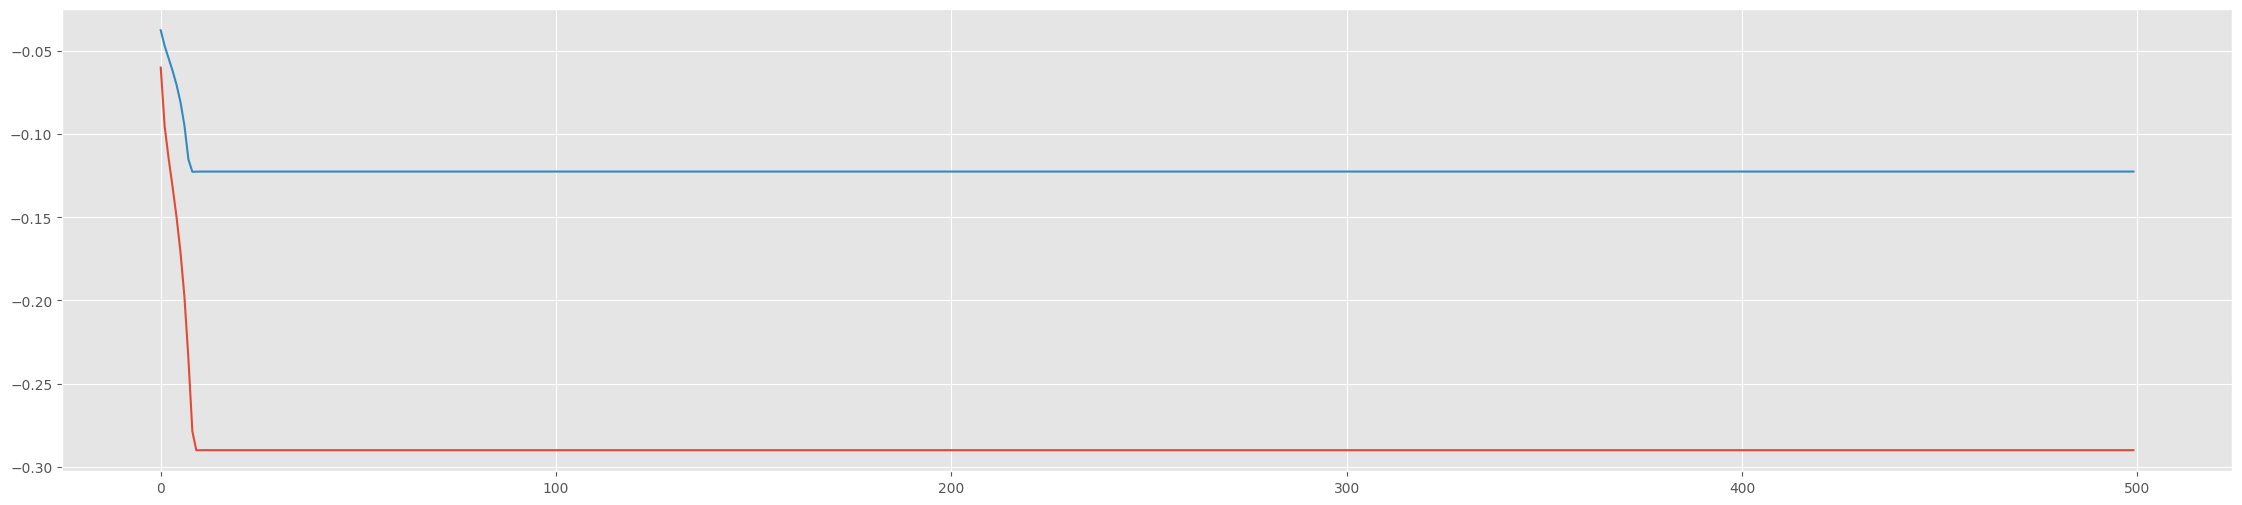

In [89]:
plt.plot(torch.tensor(inSampleLosses))
plt.plot(torch.tensor(outOfSampleLosses))

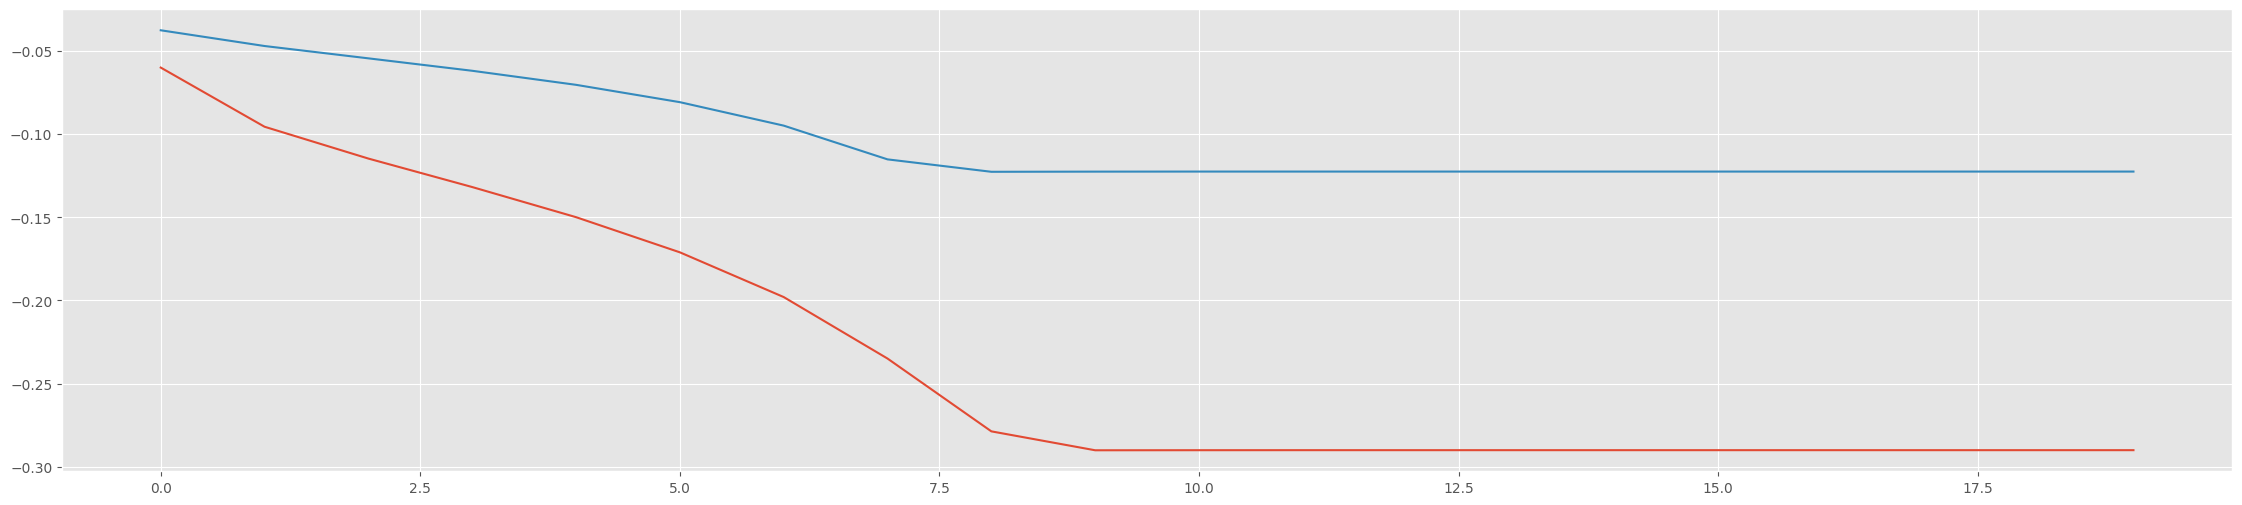

In [91]:
plt.plot(torch.tensor(inSampleLosses)[:20])
plt.plot(torch.tensor(outOfSampleLosses)[:20])

As expected, training set loss is less than test set loss, but it is good to see that test set loss does not start to increase significantly as we iterate through epochs.